In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp # for reference

import autograd.numpy as np
from neuralsolver import NNSolver

import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt

# Problem Definition

In [29]:
# Van der Pol oscillator
#http://kitchingroup.cheme.cmu.edu/blog/2013/02/02/Solving-a-second-order-ode/

mu = 1.
def f(t, y):
    # dx/dt = mu(x - 1/3*x**3 - y)
    # dy/dt = mu/x
    return [mu*(y[0] - (y[0]**3)/3. - y[1]), y[0]/mu]


y0_list = [1, 2] 

t = np.linspace(0, 10, 40).reshape(-1, 1) #training points
# use non-uniform spacing instead
#t = np.concatenate([np.linspace(0, 4, 20), np.linspace(4.1, 10, 15)])
t = t.reshape(-1, 1)

# Reference solution

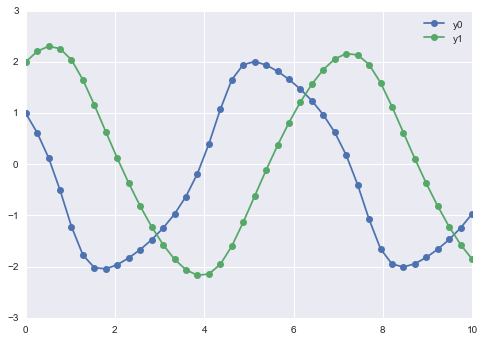

In [30]:
# reference solution using scipy package
sol = solve_ivp(f, [t.min(), t.max()], y0_list, 
                t_eval=t.ravel(), method='Radau', rtol=1e-5)
plt.plot(sol.t, sol.y[0], marker='o', label='y0')
plt.plot(sol.t, sol.y[1], marker='o', label='y1')
plt.legend()

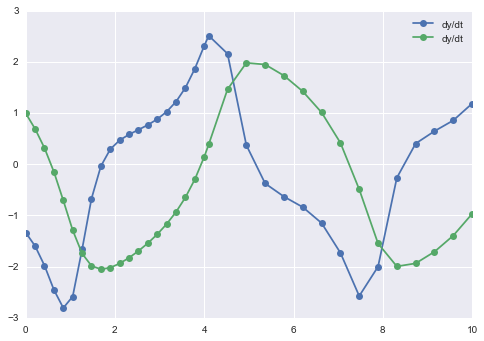

In [6]:
# reference solution using scipy package
plt.plot(sol.t, f(sol.t, sol.y)[0], marker='o', label='dy/dt')
plt.plot(sol.t, f(sol.t, sol.y)[1], marker='o', label='dy/dt')
plt.legend()

# Neural Net Training

In [34]:
nn = NNSolver(f, t, y0_list, n_hidden=20)
nn

Neural ODE Solver 
Number of equations:       2 
Initial condition y0:      [1, 2] 
Numnber of hidden units:   20 
Number of training points: 40 

In [35]:
nn.reset_weights()
%time nn.train(maxiter=1000, iprint=100)

iteration: 0 loss:  827.727232994
iteration: 100 loss:  0.163198517581
iteration: 200 loss:  0.14099963968
iteration: 300 loss:  0.0558413492241
iteration: 400 loss:  0.0217375572549
iteration: 500 loss:  0.0166205957572
iteration: 600 loss:  0.0130757366618
iteration: 700 loss:  0.00951839883898
iteration: 800 loss:  0.0076255105052
iteration: 900 loss:  0.00536880676592
         Current function value: 0.003753
         Iterations: 1000
         Function evaluations: 1108
         Gradient evaluations: 1108
CPU times: user 10.2 s, sys: 49.5 ms, total: 10.2 s
Wall time: 10.3 s


# Verifying training set

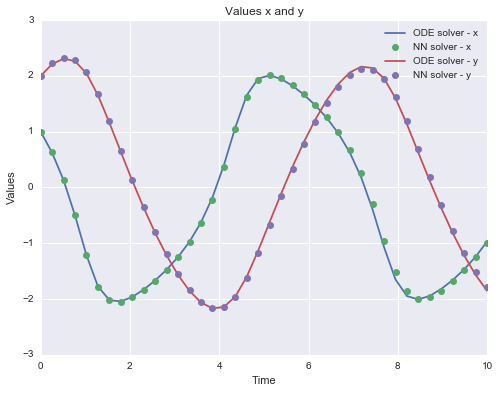

In [36]:
y_pred_list, dydt_pred_list = nn.predict()
# scipy sol
plt.figure(figsize= (8, 6))
plt.plot(sol.t, sol.y[0], label='ODE solver - x')
# nn soln
plt.plot(t, y_pred_list[0], 'o', label='NN solver - x')

plt.plot(sol.t, sol.y[1], label='ODE solver - y')
plt.plot(t, y_pred_list[1], 'o', label='NN solver - y')

plt.legend()
#plt.xlim((0, 3))

plt.title('Values x and y')
plt.ylabel('Values')
plt.xlabel('Time')


In [21]:
np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(2)])

0.076204191929279436

In [15]:
res_arr = []
for _ in range(100):
    nn = NNSolver(f, t, y0_list, n_hidden=20)
    nn.reset_weights()
    nn.train(maxiter=500)
    y_pred_list, dydt_pred_list = nn.predict()
    res_arr.append(np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(2)]))

iteration: 0 loss:  37883766.7781
         Current function value: 708.900909
         Iterations: 5
         Function evaluations: 21
         Gradient evaluations: 9
iteration: 0 loss:  763.849888972
         Current function value: 763.849889
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5
iteration: 0 loss:  320.930529757
iteration: 200 loss:  0.0556958156784
iteration: 400 loss:  0.0193173061909
         Current function value: 0.015670
         Iterations: 500
         Function evaluations: 569
         Gradient evaluations: 569
iteration: 0 loss:  7661015.73878
iteration: 200 loss:  0.138412412464
iteration: 400 loss:  0.0878787423479
         Current function value: 0.076179
         Iterations: 500
         Function evaluations: 589
         Gradient evaluations: 579
iteration: 0 loss:  41433.1608655
iteration: 200 loss:  0.0952445707378
iteration: 400 loss:  0.0875540453371
         Current function value: 0.086691
         Iterations

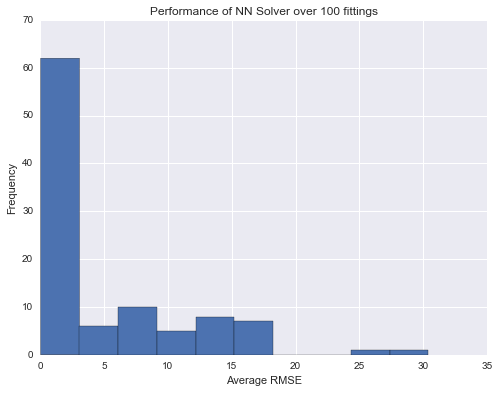

In [23]:
plt.figure(figsize= (8, 6))
plt.hist(res_arr)
plt.title('Performance of NN Solver over 100 fittings')
plt.xlabel('Average RMSE')
plt.ylabel('Frequency')

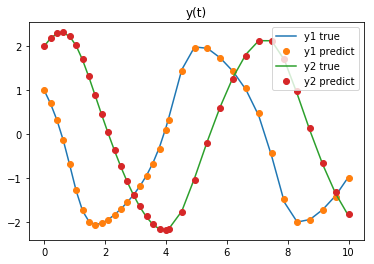

In [16]:
# scipy sol
plt.plot(sol.t, sol.y[0], label='y1 true')
# nn soln
plt.plot(t, y_pred_list[0], 'o', label='y1 predict')

plt.plot(sol.t, sol.y[1], label='y2 true')
plt.plot(t, y_pred_list[1], 'o', label='y2 predict')

plt.legend()
#plt.xlim((0, 3))
plt.title('y(t)')

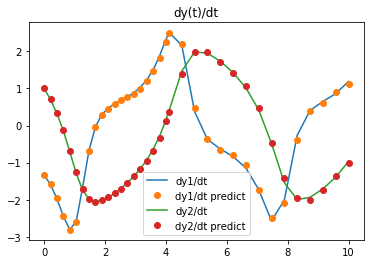

In [17]:
y_pred_list, dydt_pred_list = nn.predict()

plt.plot(sol.t, f(sol.t, sol.y)[0], label='dy1/dt')
plt.plot(t, dydt_pred_list[0], 'o', label='dy1/dt predict')

plt.plot(sol.t, f(sol.t, sol.y)[1], label='dy2/dt')
plt.plot(t, dydt_pred_list[1], 'o', label='dy2/dt predict')

plt.legend()
plt.title('dy(t)/dt')